In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import time
import copy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
import itertools
from joblib import Parallel, delayed
from sklearn.tree import plot_tree
import tqdm
from sklearn.ensemble import _gb_losses

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
train_dataset = np.loadtxt('Datasets/SpamDataset/spam.train.txt')
test_dataset = np.loadtxt('Datasets/SpamDataset/spam.test.txt')
#train_dataset[:, 0][train_dataset[:, 0] == 0.0] = -1
#test_dataset[:, 0][test_dataset[:, 0] == 0.0] = -1
X = train_dataset[:, 1:]
y = train_dataset[:, 0].astype(int)
X_test = test_dataset[:, 1:]
y_test = test_dataset[:, 0].astype(int)

***Обоснование update_terminal_region***

$$L(H) = \frac{1}{N}\sum_i^N e^{-y_i*H(x_i)}$$ 
$$L(H + h) \approx L(H) + \sum_i^N \frac{\partial L(H)}{\partial H(x_i)}h(x_i) + \sum_i^N \frac{\partial^2 L(H)}{\partial^2 H(x_i)}\frac{h(x_i)^2}{2} + o(h^2)$$
$$\sum_{i\in R_t} \frac{\partial L(H)}{\partial H(x_i)}h_t + \frac{\partial^2 L(H)}{\partial^2 H(x_i)}\frac{h_t^2}{2} \rightarrow min$$
$$h_t\sum_{i\in R_t} \frac{\partial L(H)}{\partial H(x_i)} + \frac{h_t^2}{2}\sum_{i\in R_t} \frac{\partial^2 L(H)}{\partial^2 H(x_i)} \rightarrow min$$
$$ h_t = -\frac{b}{2a}$$
$$ h_t = -\frac{\sum_{i\in R_t} \frac{\partial L(H)}{\partial H(x_i)}}{\sum_{i\in R_t} \frac{\partial^2 L(H)}{\partial^2 H(x_i)}}$$
$$ \frac{\partial L(H)}{\partial H(x_i)} = \frac{1}{N}-y_i e^{-y_iH(x_i)}$$
$$ \frac{\partial^2 L(H)}{\partial^2 H(x_i)} = \frac{1}{N}e^{-y_iH(x_i)}$$

***GradientBoosting Adaloss***

In [4]:
class MyDecisionTreeNode:
    def __init__(self, random_state=np.random.RandomState(seed=0)):
        self.leaf = False
        self.feature_idx = None
        self.split_bound = None
        self.left = None
        self.right = None
        self.value = None
        self.random_state = random_state
    
    def impurity(self, sum1, sum2, ssum1, ssum2, n1, n2):
        if n1 == 0 or n2 == 0:
            return np.inf
        N = n1 + n2
        mse1 = ssum1 - (sum1**2)/(n1)
        mse2 = ssum2 - (sum2**2)/(n2)
        return mse1/N + mse2/N
    
    def fit(self, X, y, cur_depth):
        parent_imp = np.var(y)
        self.value = np.mean(y)
        if cur_depth == 0 or parent_imp < 1e-60 or len(y) <= 2:
            self.leaf = True
            self.value = np.mean(y)
        else:
            min_impurity = np.inf
            min_feature = None
            min_split_bound = None
            min_less = None
            all_falses = np.zeros_like(y).astype(bool)
            features = np.random.permutation(X.shape[1])
            all_ssum = np.sum(y**2)
            all_sum = np.sum(y)
            for i in features:
                argsorted_features = np.argsort(X[:, i])
                less = np.zeros_like(y).astype(bool)
                sum1 = 0
                sum2 = np.array(all_sum)
                ssum1 = 0
                ssum2 = np.array(all_ssum)
                n1 = 0
                n2 = len(y)
                for k, f in enumerate(argsorted_features[:-1]):
                    less[f] = True
                    sum1 += y[f]
                    sum2 -= y[f]
                    ssum1 += y[f]**2
                    ssum2 -= y[f]**2
                    n1 += 1
                    n2 -= 1
                    if X[f, i] < X[argsorted_features[k + 1], i]:
                        cur_impurity = self.impurity(sum1, sum2, ssum1, ssum2, n1, n2)
                        if cur_impurity < min_impurity:
                            min_feature = i
                            min_split_bound = (X[f, i] + X[argsorted_features[k + 1], i]) / 2.0
                            min_less = copy.deepcopy(less)
                            min_impurity = cur_impurity
            self.feature_idx = min_feature
            self.split_bound = min_split_bound
            self.left = MyDecisionTreeNode(random_state=self.random_state)
            self.left.fit(X[min_less], y[min_less], cur_depth - 1)
            self.right = MyDecisionTreeNode(random_state=self.random_state)
            self.right.fit(X[~min_less], y[~min_less], cur_depth - 1)
        
    def predict(self, X):
        if self.leaf:
            return np.zeros(len(X)).astype(float) + self.value
        else:
            mask = X[:, self.feature_idx] <= self.split_bound
            output2 = self.left.predict(X[mask])
            output1 = self.right.predict(X[~mask])
            cur_prediction = np.zeros(len(X))
            cur_prediction[mask] = output2
            cur_prediction[~mask] = output1
            return cur_prediction
    
    def print_leafs(self):
        if self.leaf == True:
            print(round(self.value, 3), end=' ')
        else:
            self.left.print_leafs()
            self.right.print_leafs()
    
    def update_terminal_regions(self, X, y_true, y_raw):
        if self.leaf:
            y_ = 2. * y_true - 1.

            numerator = np.sum(y_ *  np.exp(-y_ * y_raw))
            denominator = np.sum(np.exp(-y_ * y_raw))
            if abs(denominator) < 1e-150:
                self.value = 0.0
            else:
                self.value = numerator / denominator
        else:
            mask = X[:, self.feature_idx] <= self.split_bound
            self.left.update_terminal_regions(X[mask], y_true[mask], y_raw[mask])
            self.right.update_terminal_regions(X[~mask], y_true[~mask], y_raw[~mask])
            
        
            
            
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=3, random_state=0):
        self.max_depth = max_depth
        self.random_state = np.random.RandomState(seed=random_state)
        self.root = MyDecisionTreeNode(random_state=self.random_state)
        
    def fit(self, X, y):
        self.root.fit(X, y, self.max_depth)
    
    def predict(self, X):
        return self.root.predict(X)

In [5]:
class MyGradientBoostingClassifier():
    def __init__(self, lr=0.1, random_state=0, n_estimators=100, max_depth=3):
        self.lr = lr
        self.models = []
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.max_depth = max_depth
    def negative_gradient(self, y, y_pred):
        y_ = -(2*y - 1)
        return y_ * np.exp(y_*y_pred)
    
    def fit(self, X, y):
        prediction = np.zeros_like(y).astype(float)        
        for i in range(self.n_estimators):
            print(i, self.n_estimators, self.max_depth)
            res = self.negative_gradient(y, prediction)
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, res)
            tree.root.update_terminal_regions(X, y, prediction)
            prediction += self.lr * tree.predict(X)
            self.models.append(tree)
    def predict(self, X, n_use=None):
        if n_use is None:
            n_use = len(self.models)
        prediction = np.zeros(X.shape[0]).astype(float)
        for i in range(n_use):
            cur_prediction = self.lr * self.models[i].predict(X)
            prediction += cur_prediction
        prediction = (prediction >= 0).astype(int)
        return prediction

***Testing***

In [14]:
depth = [1, 3, 5]
tmp = [i for i in range(50, 301, 25)]
n_estimators = [10, 20, 30, 40]

In [15]:
n_estimators.extend(tmp)

In [7]:
def test_my_clf(data):
    X = data[0]
    y = data[1]
    depth = data[2]
    n_estimators = data[3]
    g = MyGradientBoostingClassifier(n_estimators=n_estimators, max_depth=depth)
    g.fit(X, y)
    return (g)

In [8]:
def exp_loss(y, y_pred):
    return np.mean(np.exp(-(2*y - 1)*(2*y_pred - 1)))

In [9]:
models = Parallel(n_jobs=3)(delayed(test_my_clf)(c) for c in [(X, y, d, 300) for d in depth])

In [17]:
my_exp_losses_test = [[], [], []]
exp_losses_test = [[], [], []]
my_exp_losses_train = [[], [], []]
exp_losses_train = [[], [], []]
for i, m in enumerate(models):
    for estim in n_estimators:
        my_exp_losses_test[i].append(exp_loss(y_test, m.predict(X_test, n_use=estim)))
        my_exp_losses_train[i].append(exp_loss(y, m.predict(X, n_use=estim)))
        gb = GradientBoostingClassifier(max_depth=depth[i], learning_rate=0.1, random_state=1800, n_estimators=estim, loss='exponential', init='zero', criterion='mse')
        gb.fit(X, y)
        exp_losses_test[i].append(exp_loss(y_test, gb.predict(X_test)))
        exp_losses_train[i].append(exp_loss(y, gb.predict(X)))

In [18]:
def plot_result(n_trees, my_loss_train, loss_train, my_loss_test, loss_test, metrics_name='exp_loss'):
    n_trees, my_loss_train, loss_train = np.array(n_trees), np.array(my_loss_train), np.array(loss_train)
    my_loss_test, loss_test = np.array(my_loss_test), np.array(loss_test) 
    
    
    error = np.multiply(loss_test, 0.03)

    fig, (ax1,ax2) = plt.subplots(1, 2)
    fig.set_figheight(6)
    fig.set_figwidth(27)
    ax1.plot(n_trees[:len(my_loss_test)], my_loss_test, label='My GB')
    ax1.plot(n_trees[:len(loss_test)], loss_test, label='Sklearn')

    ax1.fill_between(n_trees[:len(loss_test)], (loss_test - error), (loss_test+error), color='g', alpha=.1)
    ax1.set_xlabel("n_estimators")
    ax1.set_ylabel(metrics_name)
    ax1.title.set_text('Test')
    ax1.legend()
    
    error = np.multiply(loss_train, 0.03)

    ax2.plot(n_trees[:len(my_loss_train)], my_loss_train, label='My GB')
    ax2.plot(n_trees[:len(loss_train)], loss_train, label='Sklearn')

    ax2.fill_between(n_trees[:len(loss_train)], (loss_train-error), (loss_train+error), color='g', alpha=.1)
    ax2.set_xlabel("n_estimators")
    ax2.set_ylabel(metrics_name)
    ax2.title.set_text('Train')
    ax2.legend()
    
    plt.show()

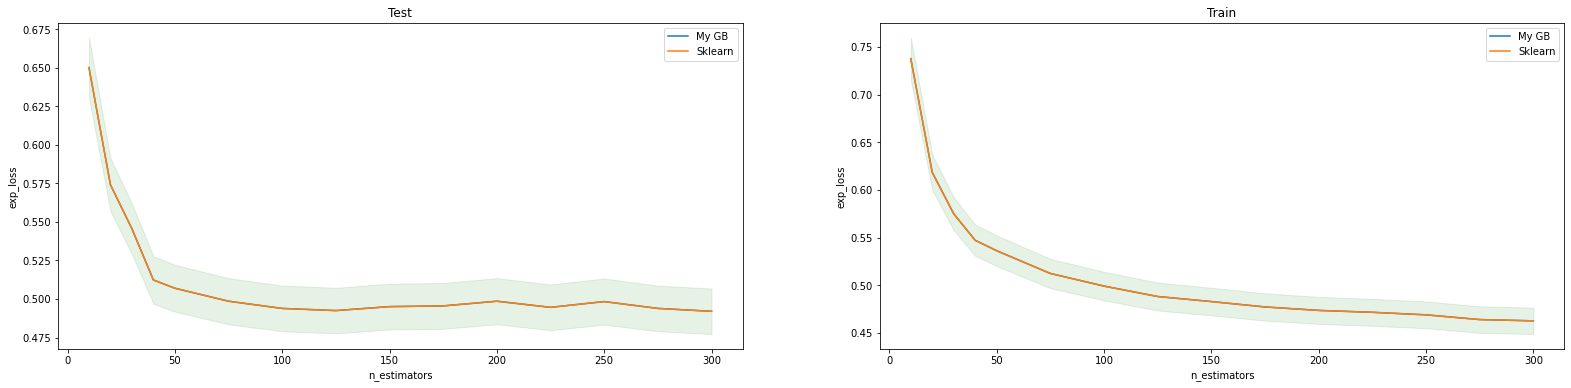

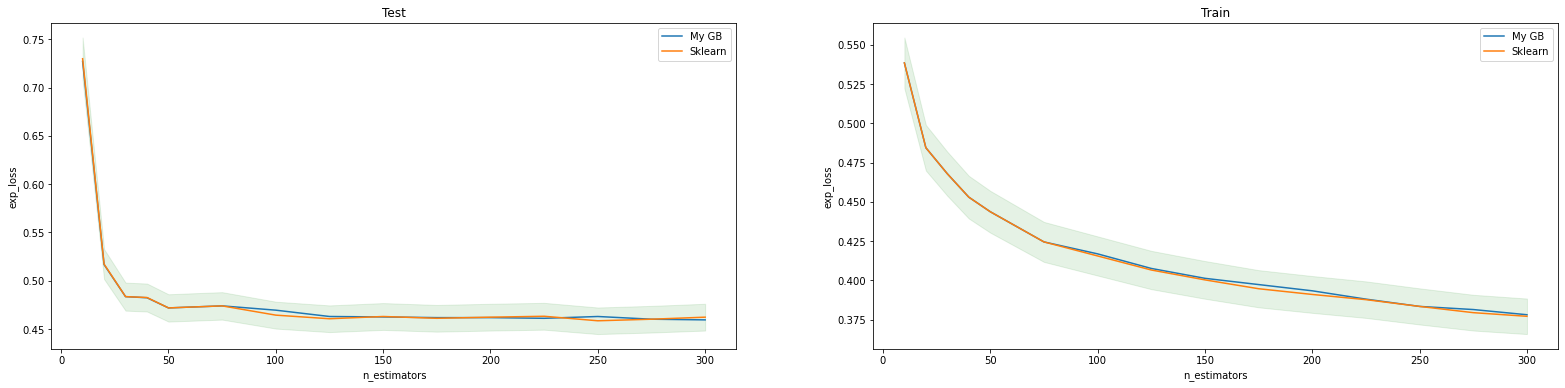

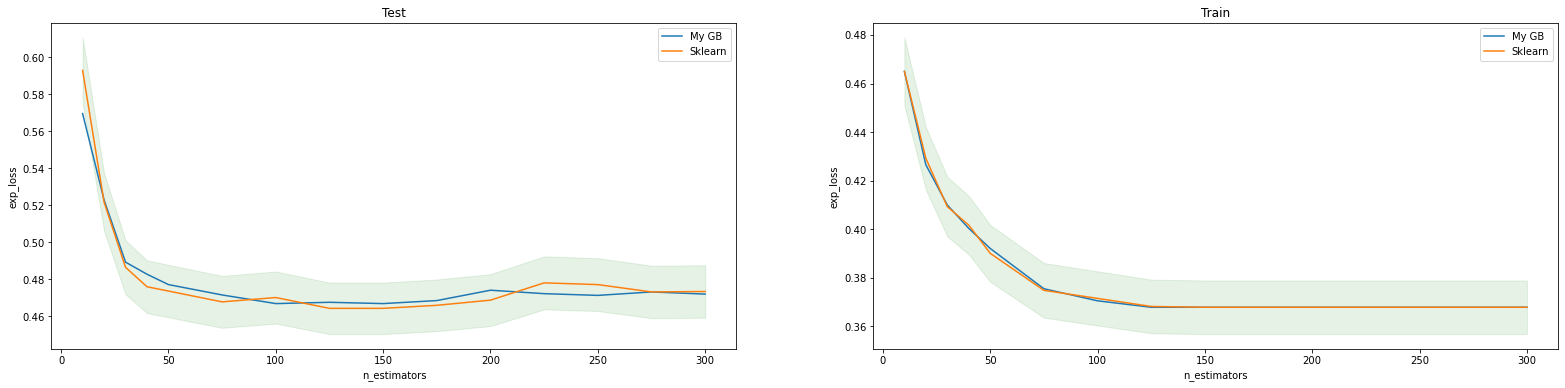

In [19]:
for i in range(len(depth)):
    plot_result(n_estimators, my_exp_losses_train[i], exp_losses_train[i], my_exp_losses_test[i], exp_losses_test[i])

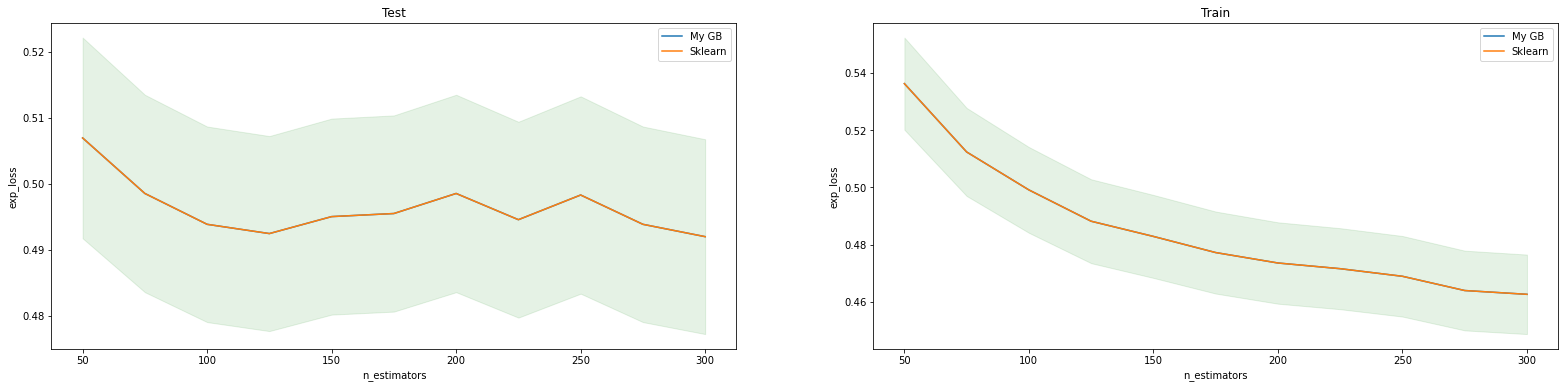

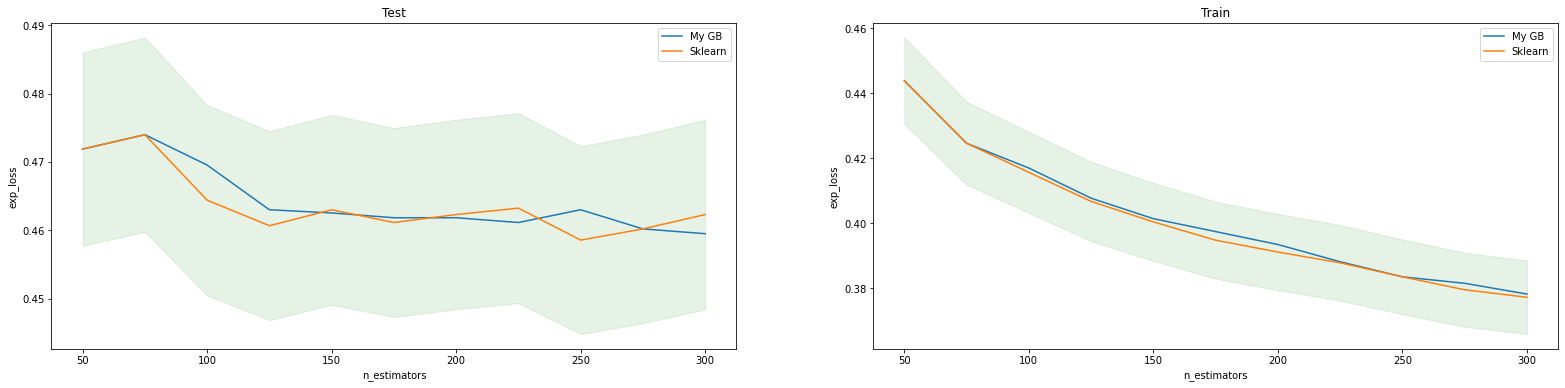

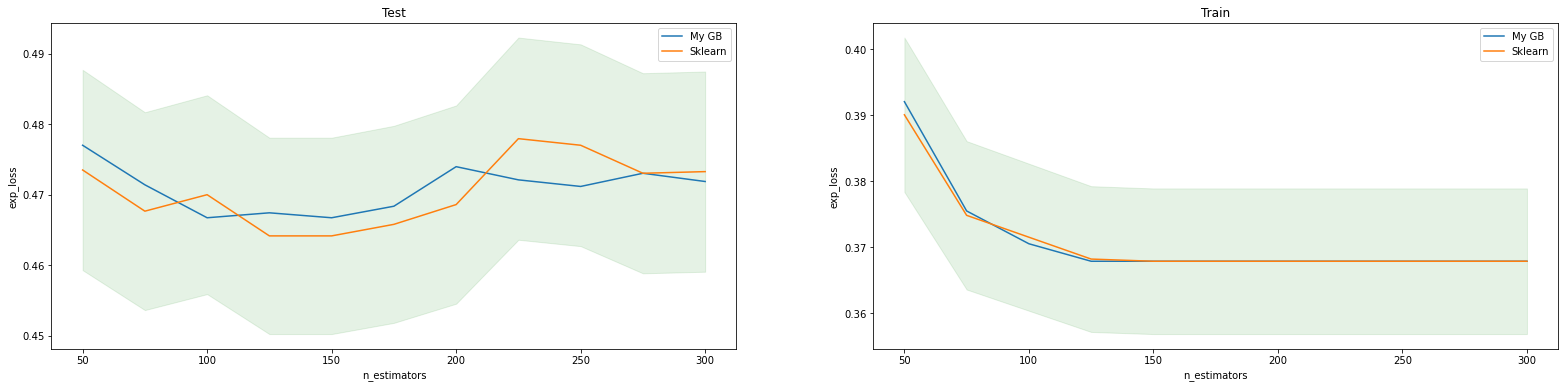

In [12]:
for i in range(len(depth)):
    plot_result(n_estimators, my_exp_losses_train[i], exp_losses_train[i], my_exp_losses_test[i], exp_losses_test[i])